In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = True

In [3]:
# some important parameters
pre_day = 5
window_size = 12*24*7 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [13]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

Writing HTML: 100%|██████████| 16/16 [00:54<00:00,  3.42s/it]

Visualization saved at visualization/raw_data/*.html


In [ ]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [7]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [8]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [9]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...         max
13       metric.STATUS_IN

In [10]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_hourly_mean_values(downsampled_data, failure_sessions, extended_feature_cols, 'visualization', 'downsampled_data')

Writing HTML: 100%|██████████| 16/16 [01:42<00:00,  6.38s/it]

Visualization saved at visualization/downsampled_data/*.html


### Data Cleaning

In [11]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [12]:
visualize_failure_timeline(filtered_sessions)

In [13]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [14]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6064
Total rows: 837811


### Feature Engineering

In [15]:
downsampled_data['hour_of_day'] = downsampled_data['event_local_time'].dt.hour
downsampled_data['month_of_year'] = downsampled_data['event_local_time'].dt.month
extended_feature_cols += ['hour_of_day', 'month_of_year']


In [16]:
if performe_visualization:
    visualize_hourly_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data')

Writing HTML: 100%|██████████| 16/16 [01:39<00:00,  6.21s/it]

Visualization saved at visualization/processed_data/*.html


### Split Dataset

In [17]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [18]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_of_day',
 'month_of_year']

### Standardization

In [19]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day', 'month_of_year']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [20]:
if performe_visualization:
    visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data')
    visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data')
    visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data')

Writing HTML: 100%|██████████| 16/16 [01:06<00:00,  4.14s/it]


Visualization saved at visualization/train_data/*.html


Writing HTML: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Visualization saved at visualization/val_data/*.html


Writing HTML: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

Visualization saved at visualization/test_data/*.html


### Create Dataset/Data Loader

In [21]:
stride = 1
window_size = 2*24*7 # 30 minutes * 24 * 7 = 1 week

In [23]:
positive_train_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)
negative_train_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=6)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 21.51it/s]


In [24]:
from torch.utils.data import DataLoader


train_ds = combine_dataset([positive_train_ds, negative_train_ds])
del positive_train_ds, negative_train_ds

val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 28.36it/s]


In [25]:
train_ds.X.shape

torch.Size([88957, 336, 16])

In [26]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    85117
 1.0     3840
 dtype: int64,
 0.0    134318
 1.0       720
 dtype: int64,
 0.0    130295
 1.0      1200
 dtype: int64)

In [27]:
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler
import torch

num_samples = int(len(train_ds)*0.15 ) # 10% of the training dataset size

# 假設 y 是樣本的 label 張量
class_sample_count = pd.value_counts(train_ds.y.numpy())
weights = 1. / class_sample_count
sample_weights = weights[train_ds.y.numpy()].to_numpy() # 每個樣本對應的抽樣權重

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_samples,
    replacement=True
)
print(weights, num_samples)

0.0    0.000012
1.0    0.000260
dtype: float64 13343


In [28]:
random_sampler = RandomSampler(val_ds, num_samples=int(len(val_ds)*0.3), replacement=True)

In [29]:
batch_size = 2**9

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=balanced_sampler,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, sampler=random_sampler, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [ ]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=48, lstm_hidden_size=96)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 建議先用較溫和的 pos_weight（例：5），再用驗證集掃描最佳值
pos_weight_value = 2.0
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float)).to('cuda')


In [ ]:
model.load_state_dict(torch.load(r'model\0813_1935\epoch_50.pth', weights_only=True))

<All keys matched successfully>

In [ ]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=50, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=5,
    save_path='model/0813_1935'
)

Model moved to cuda
Resuming training from epoch 51
[Epoch 51/101] Step 0/27 - Loss: 0.4514
[Epoch 51/101] Step 25/27 - Loss: 0.4506
🔁 Epoch 51 finished. Avg Train Loss: 0.4966
✅ Validation Loss: 0.7756 | Acc: 70.61% | AUC-PR: 0.0143 | baseline: 0.0053 | uplift: 2.70x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 52/101] Step 0/27 - Loss: 0.4149
[Epoch 52/101] Step 25/27 - Loss: 0.4037
🔁 Epoch 52 finished. Avg Train Loss: 0.4007
✅ Validation Loss: 0.6081 | Acc: 80.56% | AUC-PR: 0.0098 | baseline: 0.0052 | uplift: 1.88x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 53/101] Step 0/27 - Loss: 0.4104
[Epoch 53/101] Step 25/27 - Loss: 0.3467
🔁 Epoch 53 finished. Avg Train Loss: 0.4122
✅ Validation Loss: 0.7047 | Acc: 76.53% | AUC-PR: 0.0107 | baseline: 0.0054 | uplift: 1.97x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 54/101] Step 0/27 - Loss: 0.3668
[Epoch 54/101] Step 25/27 - L

KeyboardInterrupt: 

In [50]:
log = pd.read_csv('model/0813_1935/training_log.csv')

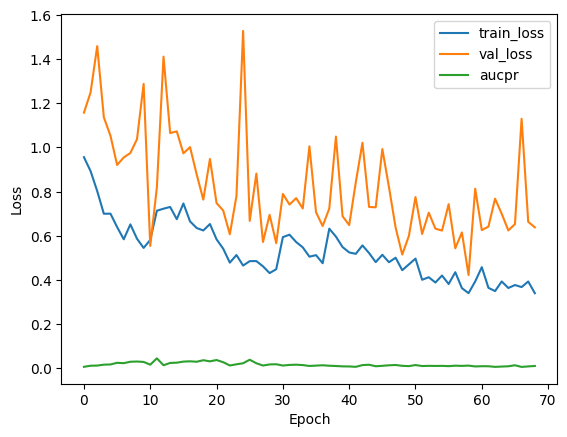

In [51]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [57]:
model.load_state_dict(torch.load(r'model\0813_1935\epoch_20.pth', weights_only=True))

<All keys matched successfully>

Performance on Training Set:


Testing: 100%|██████████| 174/174 [00:09<00:00, 19.02it/s]


🔍 Test Loss: 0.7965 | Accuracy: 68.48%
              precision    recall  f1-score   support

      Normal       0.99      0.68      0.80     85117
     Failure       0.11      0.86      0.19      3840

    accuracy                           0.68     88957
   macro avg       0.55      0.77      0.50     88957
weighted avg       0.95      0.68      0.78     88957

[[57629 27488]
 [  547  3293]]
ROC AUC: 0.8510


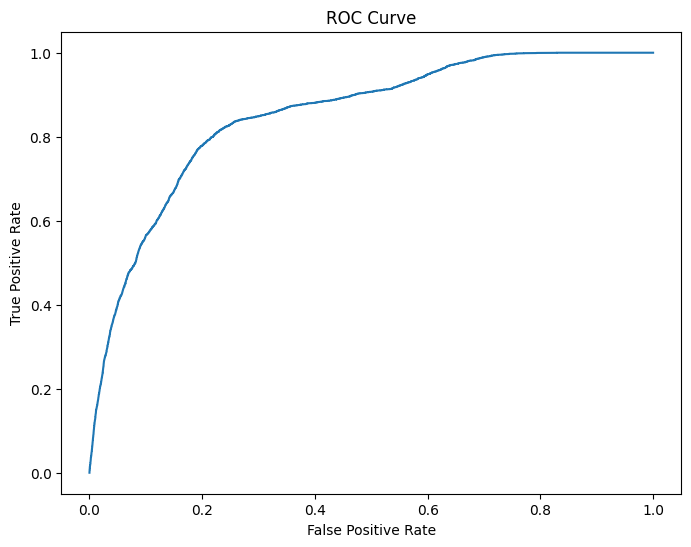

In [58]:
print("Performance on Training Set:")
train_loader_eval = DataLoader(train_ds, batch_size=batch_size,  num_workers=6, pin_memory=True)
evaluate_model(model, train_loader_eval, best_threshold=0.5, criterion=criterion)

In [59]:
val_loader_for_eval = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
trues, predictions, outputs = test_loop(model, val_loader_for_eval, device='cuda', criterion=criterion)

Testing: 100%|██████████| 264/264 [00:10<00:00, 24.54it/s]

🔍 Test Loss: 0.9464 | Accuracy: 70.02%


In [60]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresholds = precision_recall_curve(trues, outputs, pos_label=1)

target_recall = 0.8
idx = next(i for i,r in enumerate(rec) if r < target_recall) - 1
best_threshold = thresholds[idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={prec[idx]:.3f}")


Threshold for recall ≥ 0.8: 0.3013, Precision=0.006


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.33      0.50    134318
     Failure       0.01      0.80      0.01       720

    accuracy                           0.33    135038
   macro avg       0.50      0.57      0.25    135038
weighted avg       0.99      0.33      0.49    135038

[[44480 89838]
 [  144   576]]
ROC AUC: 0.7521


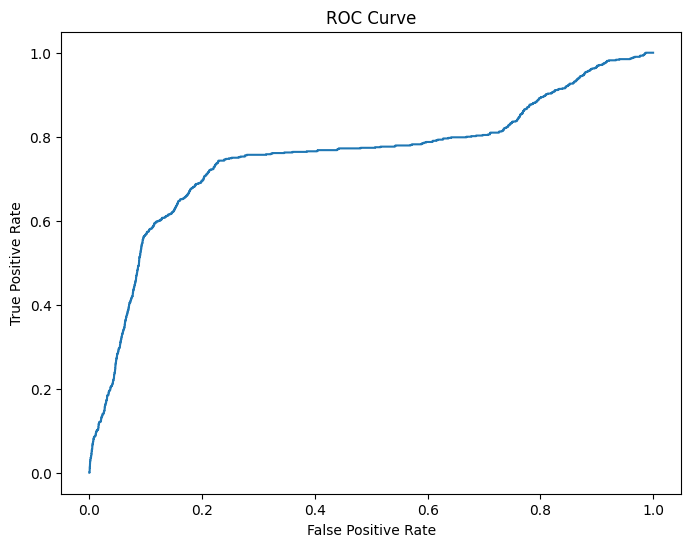

In [61]:
predictions = (outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(trues, predictions, outputs)

Performance on Test Set:


Testing: 100%|██████████| 257/257 [00:10<00:00, 24.14it/s]


🔍 Test Loss: 0.8782 | Accuracy: 23.05%
              precision    recall  f1-score   support

      Normal       0.99      0.23      0.37    130295
     Failure       0.01      0.67      0.02      1200

    accuracy                           0.23    131495
   macro avg       0.50      0.45      0.19    131495
weighted avg       0.98      0.23      0.37    131495

[[ 29507 100788]
 [   393    807]]
ROC AUC: 0.5864


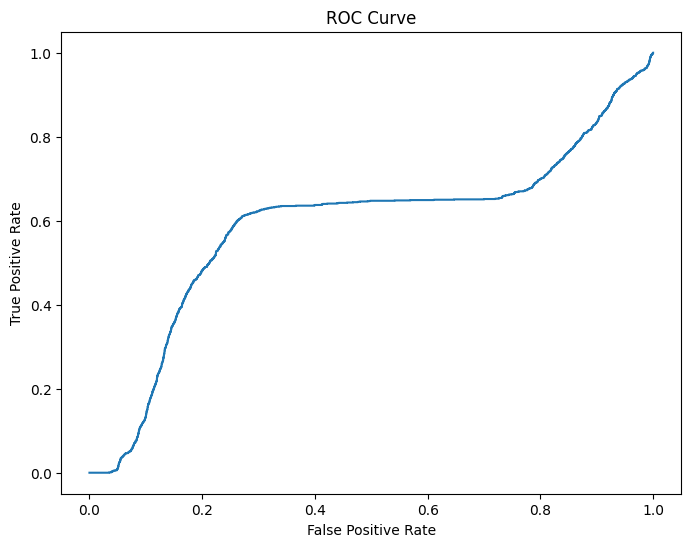

In [62]:
print("Performance on Test Set:")
evaluate_model(model, test_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)